In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc

In [3]:
def get_mae(model):
    train_pred = model.predict(X_train)
    score = mean_absolute_error(y_train,train_pred)
    print(model.__class__.__name__, " train MAE: ", np.round(score,3))
    pred = model.predict(X_test)
    score = mean_absolute_error(y_test,pred)
    print(model.__class__.__name__, " MAE: ", np.round(score,3))

In [4]:
def get_maes(models):
    scores = []
    for model in models:
        score = get_mae(model)
        # scores.append(score)
    # return scores

In [5]:

def get_r2score(model):
    train_pred = model.predict(X_train)
    pred = model.predict(X_test)
    train_score = r2_score(y_train,train_pred)
    score = r2_score(y_test,pred)
    print(model.__class__.__name__, " train_R2SCORE: ", np.round(train_score,3))
    print(model.__class__.__name__, " R2SCORE: ", np.round(score,3))

In [6]:
def get_rmse(model):
    train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train,train_pred)
    rmse = np.sqrt(train_mse)
    print(model.__class__.__name__, 'train RMSE: ', np.round(rmse,3))
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' RMSE: ', np.round(rmse,3))
    return rmse

In [7]:
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        # rmses.append(rmse)
    # return rmses

In [8]:
def get_r2scores(models):
    scores = []
    for model in models:
        score = get_r2score(model)
        # scores.append(score)
    # return scores

In [9]:
# Preprocessing for turn over rate
def tor_preprocessing(tor):
  tor_df = tor
  tor_val = tor_df['turn_over_rate']

  for i, val in enumerate(tor_val):
    if '정보' in val:
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif val == '(9999%)' :
      tor_df.loc[i,'turn_over_rate'] = np.NAN
    elif '(' in val:
      tmp = float(val[1:-1].replace('%',''))*0.01
      tor_df.loc[i,'turn_over_rate'] = tmp

  return tor_df

In [10]:
# Preprocessing for financial variable
def fv_preprocessing(fv):
  fv_df = fv
  afv = fv_df['average_salary']
  tfv = fv_df['total_sale']

  for i, val in enumerate(afv):
    if type(val) == str:
        if '만원' in val:
          tmp = int(val[:-2].replace(',',''))
          fv_df.loc[i,'average_salary'] = tmp
        if '회사' in val:
          fv_df.loc[i,'average_salary'] = np.NAN
        if '수집' in val:
          fv_df.loc[i,'average_salary'] = np.NAN

  for i, val in enumerate(tfv):
    if type(val) == str:
        if '조원' in val:
          tmp = float(val[:-2].replace(',',''))*1000
          fv_df.loc[i,'total_sale'] = tmp
        if '억원' in val:
          tmp = float(val[:-2].replace(',',''))
          fv_df.loc[i,'total_sale'] = tmp
        if '억' in val:
          tmp = float(val[:-1].replace(',',''))
          fv_df.loc[i,'total_sale'] = tmp
          print(fv_df.loc[i,'total_sale'])
          print(i)
        if '회사' in val:
          fv_df.loc[i,'total_sale'] = np.NAN

  return fv_df

In [11]:
combined_data = pd.read_csv("new_bow_df.csv")

In [12]:
from sklearn.model_selection import train_test_split
combined_data = combined_data[combined_data['turn_over_rate']<1]
error_firm = ['동원홈푸드','휠라홀딩스','트리','와디즈','키위컴퍼니','줌인터넷','시선인터내셔널','브이티코스메틱','유니슨이테크','씨엠비대전방송','서울비젼','더메인즈','조은시스템']
for i in error_firm:
    combined_data = combined_data[combined_data.company_name != i]
combined_data.dropna(axis=0, inplace=True)
combined_data = combined_data.drop(['Unnamed: 0'], axis=1)
combined_data = fv_preprocessing(combined_data)
tor = combined_data['turn_over_rate']
combined_data.drop('turn_over_rate', axis=1, inplace=True)


In [13]:
combined_data = combined_data.drop(['company_name'], axis = 1, inplace = False)

In [14]:
train_input, test_input, train_target, test_target = train_test_split(combined_data, tor, test_size=0.2)

In [15]:
train_input['adv_dadv_combined'] = train_input['adv'] + ' ' + train_input['dadv']
test_input['adv_dadv_combined'] = test_input['adv'] + ' ' + test_input['dadv']

In [16]:
train_text = train_input['adv_dadv_combined'].to_numpy()

In [17]:
test_text = test_input['adv_dadv_combined'].to_numpy()

In [18]:
financial_train1=train_input['average_salary'].to_numpy()
financial_train2=train_input['total_sale'].to_numpy()
financial_test1=test_input['average_salary'].to_numpy()
financial_test2=test_input['total_sale'].to_numpy()

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvector = TfidfVectorizer(max_features=10000)
text_train = tfidfvector.fit_transform(train_text)
text_test = tfidfvector.transform(test_text)

In [20]:
financial_train1 = financial_train1.reshape(-1, 1)
financial_train2 = financial_train2.reshape(-1, 1)
financial_test1 = financial_test1.reshape(-1, 1)
financial_test2 = financial_test2.reshape(-1, 1)

In [21]:
financial_train1 = financial_train1.astype(float)
financial_train2 = financial_train2.astype(float)
financial_test1 = financial_test1.astype(float)
financial_test2 = financial_test2.astype(float)

In [22]:
from scipy.sparse import hstack # tf-idf로 변환된 텍스트 데이터와 금융 데이터를 연결
X_train = hstack([text_train, financial_train1, financial_train2])  # 텍스트 데이터와 금융 데이터를 수평으로 연결
X_test = hstack([text_test, financial_test1, financial_test2])    # 테스트 데이터에 대해서도 동일하게 수행

In [23]:

y_train = train_target.to_numpy()
y_test = test_target.to_numpy()

In [24]:

text_train.shape

(1844, 10000)

In [25]:
X_train.shape

(1844, 10002)

In [26]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
print('\n')
get_r2scores(models)
print('\n')
get_maes(models)

LinearRegression train RMSE:  0.077
LinearRegression  RMSE:  0.166
Ridge train RMSE:  0.101
Ridge  RMSE:  0.155
Lasso train RMSE:  0.18
Lasso  RMSE:  0.176


LinearRegression  train_R2SCORE:  0.854
LinearRegression  R2SCORE:  0.277
Ridge  train_R2SCORE:  0.75
Ridge  R2SCORE:  0.374
Lasso  train_R2SCORE:  0.2
Lasso  R2SCORE:  0.194


LinearRegression  train MAE:  0.06
LinearRegression  MAE:  0.128
Ridge  train MAE:  0.075
Ridge  MAE:  0.117
Lasso  train MAE:  0.138
Lasso  MAE:  0.136


In [27]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):

    grid_model = GridSearchCV(model, param_grid=params, verbose=3,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train.astype(float),y_train.astype(float))
    mse = -1 * grid_model.best_score_
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('train: {0} After 5 CV, best average MSE: {1}, best average RMSE: {2}, best: {3}'.format(model.__class__.__name__,np.round(mse,4),
                                                                           np.round(rmse,4),grid_model.best_params_))

    grid_score = grid_model.score(X_test.astype(float), y_test.astype(float))
    mse = -1 * grid_score
    rmse = np.sqrt(-1*grid_score)
    print('test: {0}  MSE: {1}, RMSE: {2}, best alpha: {3}'.format(model.__class__.__name__,np.round(mse,4),
                                                                           np.round(rmse,4),grid_model.best_params_))
    return grid_model

In [33]:
from sklearn.metrics import mean_absolute_error
def get_MAE_RMSE(model):
  # 모델을 사용하여 예측값 생성
  y_pred = model.predict(X_test)

  # MAE 계산
  mae = mean_absolute_error(y_test, y_pred)
  # rmse
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(-mse)
  print('MSE: {0}, RMSE: {1}, MAE: {2}'.format(np.round(mse,4),np.round(rmse,4),np.round(mae,4)))

In [29]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def print_coeficient_graph(model):
    import matplotlib.pyplot as plt

    plt.rc('font', family='NanumBarunGothic')
    # 최적 모델 추출
    best_model = model.best_estimator_

    # 최적 모델의 단어 중요도 추출
    importances = best_model.coef_

    # 중요도가 높은 순으로 정렬
    sorted_indices = importances.argsort()[::-1]

    # 상위 N개의 단어와 가중치 출력
    top_n = 12
    for index in sorted_indices[:top_n]:
        word = tfidfvector.get_feature_names_out()[index]
        importance = importances[index]
        print(f"단어: {word}, 가중치: {importance:.4f}")

    # 한글 폰트 설정
    font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"

    rc('font', family='AppleGothic')

    plt.rcParams['axes.unicode_minus'] = False


    # 중요도가 높은 순으로 정렬된 인덱스 추출
    top_n = 12
    top_indices = sorted_indices[:top_n]

    # 상위 N개 단어와 가중치 추출
    top_words = [tfidfvector.get_feature_names_out()[index] for index in top_indices]
    top_importances = [importances[index] for index in top_indices]

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.barh(top_words, top_importances, color='skyblue')
    plt.xlabel('가중치')
    plt.title('상위 12개 단어의 가중치')
    plt.gca().invert_yaxis()  # 상위 단어가 위에 오도록 순서 뒤집기
    plt.show()

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_params = {'n_estimators': [500, 750, 1000],
             'max_depth' : [4,8,10]}
rf_reg = RandomForestRegressor(n_estimators=1000)
print_best_params(rf_reg,rf_params)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=4, n_estimators=500;, score=-0.030 total time= 1.1min
[CV 2/5] END ....max_depth=4, n_estimators=500;, score=-0.024 total time= 1.2min
[CV 3/5] END ....max_depth=4, n_estimators=500;, score=-0.028 total time= 1.1min
[CV 4/5] END ....max_depth=4, n_estimators=500;, score=-0.027 total time= 1.1min
[CV 5/5] END ....max_depth=4, n_estimators=500;, score=-0.024 total time= 1.2min
[CV 1/5] END ....max_depth=4, n_estimators=750;, score=-0.030 total time= 1.9min
[CV 2/5] END ....max_depth=4, n_estimators=750;, score=-0.024 total time= 1.8min
[CV 3/5] END ....max_depth=4, n_estimators=750;, score=-0.028 total time= 1.8min
[CV 4/5] END ....max_depth=4, n_estimators=750;, score=-0.027 total time= 1.8min
[CV 5/5] END ....max_depth=4, n_estimators=750;, score=-0.024 total time= 1.8min
[CV 1/5] END ...max_depth=4, n_estimators=1000;, score=-0.030 total time= 2.3min
[CV 2/5] END ...max_depth=4, n_estimators=1000;, 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=1000),
             param_grid={'max_depth': [4, 8, 10],
                         'n_estimators': [500, 750, 1000]},
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth= 10)
rf_reg.fit(X_train,y_train)


In [34]:
get_MAE_RMSE(rf_reg)

MSE: 0.0236, RMSE: nan, MAE: 0.1129


/var/folders/l9/rb7j48z54n96mr23h_b6tdgc0000gn/T/ipykernel_98075/3078704814.py:10: RuntimeWarning: invalid value encountered in sqrt
  rmse = np.sqrt(-mse)


(10002,)


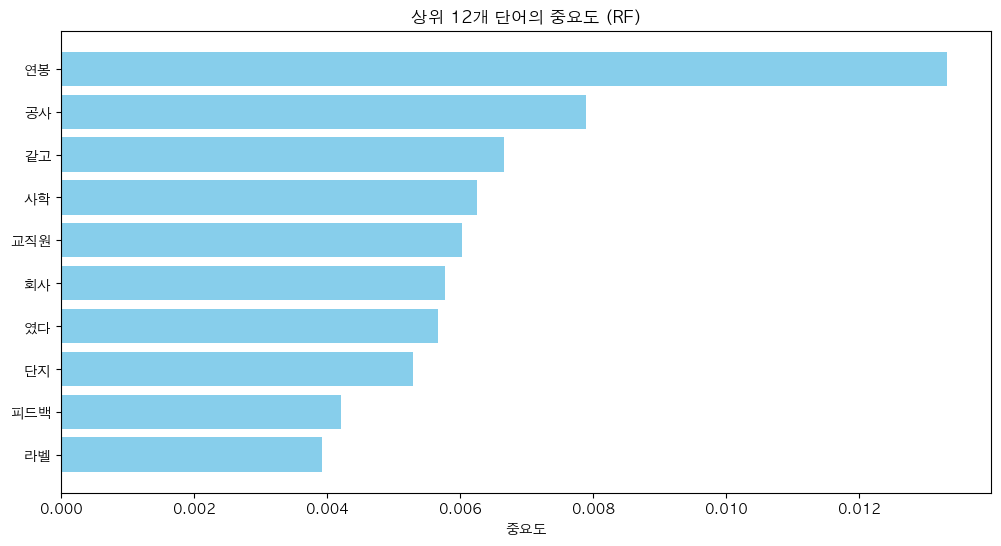

In [36]:
import matplotlib.pyplot as plt

font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"
rc('font', family='AppleGothic')
# 특성 중요도를 가져옵니다.
importances = rf_reg.feature_importances_
print(importances.shape)
# 중요도가 높은 순으로 정렬된 인덱스를 가져옵니다.
sorted_indices = importances.argsort()[::-1]
# 상위 N개의 단어와 중요도를 가져옵니다.
# 중요도가 높은 순으로 정렬된 인덱스 추출

top_n = 12
top_indices = sorted_indices[:top_n]

# 상위 N개 단어와 가중치 추출
top_words = [tfidfvector.get_feature_names_out()[index] for index in top_indices if index < len(tfidfvector.get_feature_names_out())]
top_importances = [importances[index] for index in top_indices if index < len(tfidfvector.get_feature_names_out())]

# 그래프로 시각화합니다.
plt.figure(figsize=(12, 6))
plt.barh(top_words, top_importances, color='skyblue')
plt.xlabel('중요도')
plt.title('상위 12개 단어의 중요도 (RF)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서대로 표시하기 위해 Y 축 뒤집기
plt.show()

In [ ]:
joblib.dump(rf_reg, 'tf_idf_rf_reg_model.pkl')

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_params = {'max_depth' : [4,6,8,10]}
dt_reg = DecisionTreeRegressor(max_depth=4)
print_best_params(dt_reg, dt_params)

In [ ]:
get_MAE_RMSE(dt_reg)

In [ ]:
print_coeficient_graph(dt_reg)

In [ ]:
joblib.dump(dt_reg, 'tf_idf_dt_reg_model.pkl')